# 實驗一：房價預測模型

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/taipeitechmmslab/MMSLAB-TF2/blob/master/Lab2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
    
  <td>
    <a target="_blank" href="https://github.com/taipeitechmmslab/MMSLAB-TF2/blob/master/Lab2.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

### Import必要套件

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

### 下載 House Sales in King County, USA 資料集

https://www.kaggle.com/harlfoxem/housesalesprediction

### 數據讀取並分析

In [2]:
data = pd.read_csv("kc_house_data.csv")
# 顯示dataset的形狀，共21613比資料，每一比資料有21種不同資訊。
data.shape

(21613, 21)

In [3]:
# 將顯示列數設定為25，不然會有部份資料無法顯示
pd.options.display.max_columns = 25
# head 會顯示前五行的數據
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


各個數據的簡寫分別代表下面意思：
- date：房屋出售日期。
- price：房屋價格（目標）。
- bedrooms：臥室數量。
- bathrooms：浴室數量。
- sqft_living：居住的坪數（平方英尺）。
- sqft_lot：實際的坪數（平方英尺）。
- floors：房屋總共樓層。
- waterfront：海景房。
- view：房屋是否看過。
- condition：整體條件有多好。
- grade：房屋的整體等級（根據King County評分系統）。
- sqft_above：除了地下室外的坪數（平方英尺）。
- sqft_basement：地下室的坪數（平方英尺）。
- yr_built：房屋建造時間。
- yr_renovated：何時重新裝修過（一些沒重新裝修過或是裝修紀錄沒被記錄到的數值都為0）。
- zipcode：郵政編碼。
- lat：緯度座標。
- long：經度座標。
- sqft_living15：2015年紀錄的居住坪數（可能是翻新的原因導致sqft_living15與sqft_living不同）。
- sqft_lot15：2015年紀錄的實際坪數（可能是翻新的原因導致sqft_lot15與sqft_lot不同）。

### 檢查資料的型態

資料型態總共有五種：object(string),booleab, integer, float and categorical.

In [4]:
data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

### 數據前處理
轉換資料型態：
因為數據集裡的date數據是字串（string）格式，而模型的輸入只接受數值格式，所以可以透過以下程式碼將其轉為數值，並分成年、月及日三種數據。

In [5]:
# 將date日期拆為年、月和日並轉成數值
data['year'] = pd.to_numeric(data['date'].str.slice(0, 4))
data['month'] = pd.to_numeric(data['date'].str.slice(4, 6))
data['day'] = pd.to_numeric(data['date'].str.slice(6, 8))

# 刪除沒有用的數據，inplace則是將更新後的資料存回原本的地方
data.drop(['id'], axis="columns", inplace=True)
data.drop(['date'], axis="columns", inplace=True)

data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18


分割數據集（Dataset）：將數據集切割成三個部份，訓練數據（Training data）、驗證數據（Validation data）和測試數據（Testing data）。

In [6]:
data_num = data.shape[0]
# 取得一筆與data數量相同的亂數索引，主要目的是用於打散資料
indexes = np.random.permutation(data_num)
# 並將亂數索引值分為Train、validation和test分為，這裡的劃分比例為6:2:2
train_indexes = indexes[:int(data_num *0.6)]
val_indexes = indexes[int(data_num *0.6):int(data_num *0.8)]
test_indexes = indexes[int(data_num *0.8):]
# 透過索引值從data取出訓練資料、驗證資料和測試資料
train_data = data.loc[train_indexes]
val_data = data.loc[val_indexes]
test_data = data.loc[test_indexes]

### Normalization 正規化

使用標準分數(Standard Score, 又稱z-score)將數據正規化，經過z-score正規化後數據的都會聚集在0附近， 標準差為1。 

(x - 平均值) / 標準差

In [7]:
train_validation_data = pd.concat([train_data, val_data])
mean = train_validation_data.mean()
std = train_validation_data.std()

train_data = (train_data - mean) / std
val_data = (val_data - mean) / std

### 建立Numpy array格式的訓練數據

In [8]:
x_train = np.array(train_data.drop('price', axis='columns'))
y_train = np.array(train_data['price'])
x_val = np.array(val_data.drop('price', axis='columns'))
y_val = np.array(val_data['price'])

整理過後的資料共12967筆，且一筆資料有21種資訊(所以網路輸入必須為21)。

In [9]:
x_train.shape

(12967, 21)

### 建立並訓練網路模型

這裡建構三層全連接層的網路架構，並且使用ReLU作為隱藏層的激活函數，而由於需得到線性輸出，故輸出層不使用任何激活函數。

In [10]:
# 建立一個Sequential型態的model
model = keras.Sequential(name='model-1')
# 第1層全連接層設為64個unit，將輸入形狀設定為(21, )，而實際上我們輸入的數據形狀為(batch_size, 21)
model.add(layers.Dense(64, activation='relu', input_shape=(21,)))
# 第2層全連接層設為64個unit
model.add(layers.Dense(64, activation='relu'))
# 最後一層全連接層設為1個unit
model.add(layers.Dense(1))
# 顯示網路模型架構
model.summary()

Model: "model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1408      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________


設定訓練使用的優化器、損失函數和指標函數：

In [11]:
model.compile(keras.optimizers.Adam(0.001),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

創建模型儲存目錄：

In [12]:
model_dir = 'lab2-logs/models/'
os.makedirs(model_dir)

設定回調函數：

In [13]:
# TensorBoard回調函數會幫忙紀錄訓練資訊，並存成TensorBoard的紀錄檔
log_dir = os.path.join('lab2-logs', 'model-1')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# ModelCheckpoint回調函數幫忙儲存網路模型，可以設定只儲存最好的模型，「monitor」表示被監測的數據，「mode」min則代表監測數據越小越好。
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-1.h5', 
                                        monitor='val_mean_absolute_error', 
                                        save_best_only=True, 
                                        mode='min')

訓練網路模型：

In [14]:
history = model.fit(x_train, y_train,  # 傳入訓練數據
               batch_size=64,  # 批次大小設為64
               epochs=300,  # 整個dataset訓練300遍
               validation_data=(x_val, y_val),  # 驗證數據
               callbacks=[model_cbk, model_mckp])  # Tensorboard回調函數紀錄訓練過程，ModelCheckpoint回調函數儲存最好的模型

Epoch 1/300
  1/203 [..............................] - ETA: 0s - loss: 0.7274 - mean_absolute_error: 0.7365WARNING:tensorflow:From C:\Users\m9303\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
203/203 [==============================] - 0s 2ms/step - loss: 0.3255 - mean_absolute_error: 0.3489 - val_loss: 0.2396 - val_mean_absolute_error: 0.3071
Epoch 2/300
203/203 [==============================] - 0s 1ms/step - loss: 0.2048 - mean_absolute_error: 0.2805 - val_loss: 0.2024 - val_mean_absolute_error: 0.2797
Epoch 3/300
203/203 [==============================] - 0s 965us/step - loss: 0.1767 - mean_absolute_error: 0.2610 - val_loss: 0.1670 - val_mean_absolute_error: 0.2556
Epoch 4/300
203/203 [==============================] - 0s 921us/step - loss: 0.1556 - mean_absolute_error: 0.2461 

203/203 [==============================] - 0s 746us/step - loss: 0.0587 - mean_absolute_error: 0.1650 - val_loss: 0.1288 - val_mean_absolute_error: 0.2063
Epoch 47/300
203/203 [==============================] - 0s 731us/step - loss: 0.0563 - mean_absolute_error: 0.1621 - val_loss: 0.1272 - val_mean_absolute_error: 0.2151
Epoch 48/300
203/203 [==============================] - 0s 725us/step - loss: 0.0595 - mean_absolute_error: 0.1647 - val_loss: 0.1239 - val_mean_absolute_error: 0.1988
Epoch 49/300
203/203 [==============================] - 0s 751us/step - loss: 0.0552 - mean_absolute_error: 0.1606 - val_loss: 0.1346 - val_mean_absolute_error: 0.2006
Epoch 50/300
203/203 [==============================] - 0s 812us/step - loss: 0.0558 - mean_absolute_error: 0.1610 - val_loss: 0.1149 - val_mean_absolute_error: 0.1937
Epoch 51/300
203/203 [==============================] - 0s 957us/step - loss: 0.0554 - mean_absolute_error: 0.1611 - val_loss: 0.1174 - val_mean_absolute_error: 0.2015
Epoch

Epoch 95/300
203/203 [==============================] - 0s 768us/step - loss: 0.0415 - mean_absolute_error: 0.1451 - val_loss: 0.1246 - val_mean_absolute_error: 0.1996
Epoch 96/300
203/203 [==============================] - 0s 735us/step - loss: 0.0389 - mean_absolute_error: 0.1424 - val_loss: 0.1227 - val_mean_absolute_error: 0.2037
Epoch 97/300
203/203 [==============================] - 0s 744us/step - loss: 0.0402 - mean_absolute_error: 0.1434 - val_loss: 0.1263 - val_mean_absolute_error: 0.2057
Epoch 98/300
203/203 [==============================] - 0s 792us/step - loss: 0.0414 - mean_absolute_error: 0.1461 - val_loss: 0.1242 - val_mean_absolute_error: 0.2050
Epoch 99/300
203/203 [==============================] - 0s 744us/step - loss: 0.0406 - mean_absolute_error: 0.1433 - val_loss: 0.1239 - val_mean_absolute_error: 0.2012
Epoch 100/300
203/203 [==============================] - 0s 741us/step - loss: 0.0429 - mean_absolute_error: 0.1461 - val_loss: 0.1218 - val_mean_absolute_error

203/203 [==============================] - 0s 816us/step - loss: 0.0393 - mean_absolute_error: 0.1411 - val_loss: 0.1258 - val_mean_absolute_error: 0.2025
Epoch 144/300
203/203 [==============================] - 0s 776us/step - loss: 0.0341 - mean_absolute_error: 0.1349 - val_loss: 0.1328 - val_mean_absolute_error: 0.2049
Epoch 145/300
203/203 [==============================] - 0s 869us/step - loss: 0.0343 - mean_absolute_error: 0.1343 - val_loss: 0.1299 - val_mean_absolute_error: 0.2072
Epoch 146/300
203/203 [==============================] - 0s 787us/step - loss: 0.0348 - mean_absolute_error: 0.1352 - val_loss: 0.1294 - val_mean_absolute_error: 0.2036
Epoch 147/300
203/203 [==============================] - 0s 841us/step - loss: 0.0373 - mean_absolute_error: 0.1388 - val_loss: 0.1359 - val_mean_absolute_error: 0.2080
Epoch 148/300
203/203 [==============================] - 0s 785us/step - loss: 0.0440 - mean_absolute_error: 0.1446 - val_loss: 0.1281 - val_mean_absolute_error: 0.2074


203/203 [==============================] - 0s 829us/step - loss: 0.0298 - mean_absolute_error: 0.1275 - val_loss: 0.1300 - val_mean_absolute_error: 0.2066
Epoch 192/300
203/203 [==============================] - 0s 794us/step - loss: 0.0300 - mean_absolute_error: 0.1278 - val_loss: 0.1307 - val_mean_absolute_error: 0.2064
Epoch 193/300
203/203 [==============================] - 0s 777us/step - loss: 0.0318 - mean_absolute_error: 0.1308 - val_loss: 0.1275 - val_mean_absolute_error: 0.2069
Epoch 194/300
203/203 [==============================] - 0s 741us/step - loss: 0.0324 - mean_absolute_error: 0.1320 - val_loss: 0.1332 - val_mean_absolute_error: 0.2093
Epoch 195/300
203/203 [==============================] - 0s 761us/step - loss: 0.0409 - mean_absolute_error: 0.1404 - val_loss: 0.1309 - val_mean_absolute_error: 0.2071
Epoch 196/300
203/203 [==============================] - 0s 898us/step - loss: 0.0355 - mean_absolute_error: 0.1337 - val_loss: 0.1378 - val_mean_absolute_error: 0.2151


203/203 [==============================] - 0s 840us/step - loss: 0.0283 - mean_absolute_error: 0.1252 - val_loss: 0.1348 - val_mean_absolute_error: 0.2111
Epoch 240/300
203/203 [==============================] - 0s 850us/step - loss: 0.0281 - mean_absolute_error: 0.1240 - val_loss: 0.1289 - val_mean_absolute_error: 0.2079
Epoch 241/300
203/203 [==============================] - 0s 796us/step - loss: 0.0303 - mean_absolute_error: 0.1274 - val_loss: 0.1331 - val_mean_absolute_error: 0.2068
Epoch 242/300
203/203 [==============================] - 0s 792us/step - loss: 0.0353 - mean_absolute_error: 0.1337 - val_loss: 0.1355 - val_mean_absolute_error: 0.2116
Epoch 243/300
203/203 [==============================] - 0s 779us/step - loss: 0.0306 - mean_absolute_error: 0.1275 - val_loss: 0.1795 - val_mean_absolute_error: 0.2259
Epoch 244/300
203/203 [==============================] - 0s 729us/step - loss: 0.0449 - mean_absolute_error: 0.1415 - val_loss: 0.1384 - val_mean_absolute_error: 0.2135


203/203 [==============================] - 0s 808us/step - loss: 0.0315 - mean_absolute_error: 0.1266 - val_loss: 0.1450 - val_mean_absolute_error: 0.2181
Epoch 288/300
203/203 [==============================] - 0s 809us/step - loss: 0.0410 - mean_absolute_error: 0.1374 - val_loss: 0.1335 - val_mean_absolute_error: 0.2103
Epoch 289/300
203/203 [==============================] - 0s 857us/step - loss: 0.0324 - mean_absolute_error: 0.1291 - val_loss: 0.1484 - val_mean_absolute_error: 0.2184
Epoch 290/300
203/203 [==============================] - 0s 794us/step - loss: 0.0286 - mean_absolute_error: 0.1244 - val_loss: 0.1341 - val_mean_absolute_error: 0.2157
Epoch 291/300
203/203 [==============================] - 0s 850us/step - loss: 0.0264 - mean_absolute_error: 0.1211 - val_loss: 0.1345 - val_mean_absolute_error: 0.2100
Epoch 292/300
203/203 [==============================] - 0s 788us/step - loss: 0.0254 - mean_absolute_error: 0.1184 - val_loss: 0.1348 - val_mean_absolute_error: 0.2118


### 訓練結果

In [15]:
history.history.keys()  # 查看history儲存的資訊有哪些

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

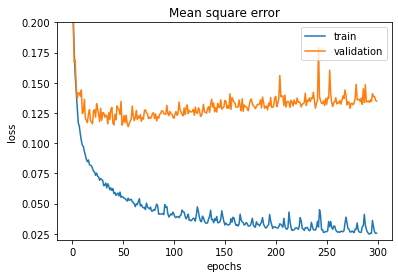

In [16]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0.02, 0.2)
plt.title('Mean square error')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')

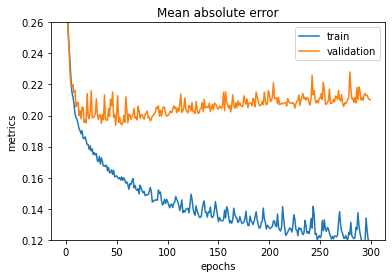

In [17]:
plt.plot(history.history['mean_absolute_error'], label='train')
plt.plot(history.history['val_mean_absolute_error'], label='validation')
plt.ylim(0.12, 0.26)
plt.title('Mean absolute error')
plt.ylabel('metrics')
plt.xlabel('epochs')
plt.legend(loc='upper right')

測試數據的誤差百分比：用測試數據預測房屋價格並與答案計算誤差百分比。

In [18]:
# 載入模型
model = keras.models.load_model('lab2-logs/models/Best-model-1.h5')
# 先將房屋價格取出
y_test = np.array(test_data['price'])
# 標準化數據
test_data = (test_data - mean) / std
# 將輸入數據存成Numpy 格式
x_test = np.array(test_data.drop('price', axis='columns'))
# 預測測試數據
y_pred = model.predict(x_test)
# 將預測結果轉換回來(因為訓練時的訓練目標也有經過標準化)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
# 計算平均的誤差百分比
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
# 顯示誤差百分比
print("Model_1 Percentage Error: {:.2f}%".format(percentage_error))

Model_1 Percentage Error: 13.60%


### TensorBoard 可視化工具

In [19]:
# 這行指令可以幫助我們直接在jupyter notebook上顯示TensorBoard
%load_ext tensorboard

In [20]:
%tensorboard --port 9530 --logdir lab2-logs

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 19740.

# 實驗二：過擬合問題

### 方法一、減少網路權重

In [21]:
model_2 = keras.Sequential(name='model-2')
model_2.add(layers.Dense(16, activation='relu', input_shape=(21,)))
model_2.add(layers.Dense(16, activation='relu'))
model_2.add(layers.Dense(1))

model_2.compile(keras.optimizers.Adam(0.001),
                loss=keras.losses.MeanSquaredError(),
                metrics=[keras.metrics.MeanAbsoluteError()])

log_dir = os.path.join('lab2-logs', 'model-2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-2.h5', 
                                             monitor='val_mean_absolute_error', 
                                             save_best_only=True, 
                                             mode='min')
model_2.fit(x_train, y_train, 
            batch_size=64 ,
            epochs=300, 
            validation_data=(x_val, y_val), 
            callbacks=[model_cbk, model_mckp])

Epoch 1/300
203/203 [==============================] - 1s 2ms/step - loss: 0.5598 - mean_absolute_error: 0.4676 - val_loss: 0.3080 - val_mean_absolute_error: 0.3683
Epoch 2/300
203/203 [==============================] - 0s 787us/step - loss: 0.2826 - mean_absolute_error: 0.3346 - val_loss: 0.2345 - val_mean_absolute_error: 0.3123
Epoch 3/300
203/203 [==============================] - 0s 760us/step - loss: 0.2331 - mean_absolute_error: 0.3044 - val_loss: 0.2192 - val_mean_absolute_error: 0.2968
Epoch 4/300
203/203 [==============================] - 0s 740us/step - loss: 0.2119 - mean_absolute_error: 0.2878 - val_loss: 0.1943 - val_mean_absolute_error: 0.2763
Epoch 5/300
203/203 [==============================] - 0s 749us/step - loss: 0.1987 - mean_absolute_error: 0.2785 - val_loss: 0.1813 - val_mean_absolute_error: 0.2637
Epoch 6/300
203/203 [==============================] - 0s 726us/step - loss: 0.1851 - mean_absolute_error: 0.2669 - val_loss: 0.1734 - val_mean_absolute_error: 0.2542


203/203 [==============================] - 0s 759us/step - loss: 0.0955 - mean_absolute_error: 0.1947 - val_loss: 0.1253 - val_mean_absolute_error: 0.2022
Epoch 49/300
203/203 [==============================] - 0s 740us/step - loss: 0.0964 - mean_absolute_error: 0.1955 - val_loss: 0.1327 - val_mean_absolute_error: 0.2040
Epoch 50/300
203/203 [==============================] - 0s 715us/step - loss: 0.0954 - mean_absolute_error: 0.1949 - val_loss: 0.1304 - val_mean_absolute_error: 0.2047
Epoch 51/300
203/203 [==============================] - 0s 833us/step - loss: 0.0931 - mean_absolute_error: 0.1940 - val_loss: 0.1173 - val_mean_absolute_error: 0.1981
Epoch 52/300
203/203 [==============================] - 0s 706us/step - loss: 0.0935 - mean_absolute_error: 0.1932 - val_loss: 0.1187 - val_mean_absolute_error: 0.1983
Epoch 53/300
203/203 [==============================] - 0s 854us/step - loss: 0.0916 - mean_absolute_error: 0.1921 - val_loss: 0.1164 - val_mean_absolute_error: 0.1973
Epoch

Epoch 97/300
203/203 [==============================] - 0s 666us/step - loss: 0.0825 - mean_absolute_error: 0.1855 - val_loss: 0.1204 - val_mean_absolute_error: 0.1958
Epoch 98/300
203/203 [==============================] - 0s 694us/step - loss: 0.0829 - mean_absolute_error: 0.1858 - val_loss: 0.1183 - val_mean_absolute_error: 0.1950
Epoch 99/300
203/203 [==============================] - 0s 700us/step - loss: 0.0841 - mean_absolute_error: 0.1868 - val_loss: 0.1198 - val_mean_absolute_error: 0.1956
Epoch 100/300
203/203 [==============================] - 0s 681us/step - loss: 0.0819 - mean_absolute_error: 0.1854 - val_loss: 0.1272 - val_mean_absolute_error: 0.1973
Epoch 101/300
203/203 [==============================] - 0s 766us/step - loss: 0.0829 - mean_absolute_error: 0.1860 - val_loss: 0.1232 - val_mean_absolute_error: 0.1986
Epoch 102/300
203/203 [==============================] - 0s 715us/step - loss: 0.0821 - mean_absolute_error: 0.1860 - val_loss: 0.1257 - val_mean_absolute_err

203/203 [==============================] - 0s 680us/step - loss: 0.0771 - mean_absolute_error: 0.1823 - val_loss: 0.1239 - val_mean_absolute_error: 0.1929
Epoch 146/300
203/203 [==============================] - 0s 699us/step - loss: 0.0786 - mean_absolute_error: 0.1825 - val_loss: 0.1282 - val_mean_absolute_error: 0.1974
Epoch 147/300
203/203 [==============================] - 0s 683us/step - loss: 0.0782 - mean_absolute_error: 0.1821 - val_loss: 0.1182 - val_mean_absolute_error: 0.1925
Epoch 148/300
203/203 [==============================] - 0s 706us/step - loss: 0.0791 - mean_absolute_error: 0.1834 - val_loss: 0.1248 - val_mean_absolute_error: 0.1973
Epoch 149/300
203/203 [==============================] - 0s 705us/step - loss: 0.0773 - mean_absolute_error: 0.1821 - val_loss: 0.1191 - val_mean_absolute_error: 0.1931
Epoch 150/300
203/203 [==============================] - 0s 695us/step - loss: 0.0772 - mean_absolute_error: 0.1813 - val_loss: 0.1203 - val_mean_absolute_error: 0.1930


203/203 [==============================] - 0s 668us/step - loss: 0.0752 - mean_absolute_error: 0.1808 - val_loss: 0.1198 - val_mean_absolute_error: 0.1925
Epoch 194/300
203/203 [==============================] - 0s 751us/step - loss: 0.0745 - mean_absolute_error: 0.1797 - val_loss: 0.1308 - val_mean_absolute_error: 0.1956
Epoch 195/300
203/203 [==============================] - 0s 725us/step - loss: 0.0750 - mean_absolute_error: 0.1801 - val_loss: 0.1273 - val_mean_absolute_error: 0.1943
Epoch 196/300
203/203 [==============================] - 0s 665us/step - loss: 0.0743 - mean_absolute_error: 0.1789 - val_loss: 0.1250 - val_mean_absolute_error: 0.1948
Epoch 197/300
203/203 [==============================] - 0s 751us/step - loss: 0.0747 - mean_absolute_error: 0.1800 - val_loss: 0.1268 - val_mean_absolute_error: 0.1956
Epoch 198/300
203/203 [==============================] - 0s 693us/step - loss: 0.0749 - mean_absolute_error: 0.1797 - val_loss: 0.1264 - val_mean_absolute_error: 0.1933


203/203 [==============================] - 0s 701us/step - loss: 0.0732 - mean_absolute_error: 0.1783 - val_loss: 0.1376 - val_mean_absolute_error: 0.1982
Epoch 242/300
203/203 [==============================] - 0s 854us/step - loss: 0.0733 - mean_absolute_error: 0.1781 - val_loss: 0.1284 - val_mean_absolute_error: 0.1943
Epoch 243/300
203/203 [==============================] - 0s 727us/step - loss: 0.0730 - mean_absolute_error: 0.1780 - val_loss: 0.1283 - val_mean_absolute_error: 0.1949
Epoch 244/300
203/203 [==============================] - 0s 792us/step - loss: 0.0723 - mean_absolute_error: 0.1775 - val_loss: 0.1373 - val_mean_absolute_error: 0.2000
Epoch 245/300
203/203 [==============================] - 0s 680us/step - loss: 0.0729 - mean_absolute_error: 0.1777 - val_loss: 0.1281 - val_mean_absolute_error: 0.1943
Epoch 246/300
203/203 [==============================] - 0s 672us/step - loss: 0.0722 - mean_absolute_error: 0.1772 - val_loss: 0.1352 - val_mean_absolute_error: 0.1953


203/203 [==============================] - 0s 670us/step - loss: 0.0727 - mean_absolute_error: 0.1771 - val_loss: 0.1300 - val_mean_absolute_error: 0.1930
Epoch 290/300
203/203 [==============================] - 0s 669us/step - loss: 0.0717 - mean_absolute_error: 0.1765 - val_loss: 0.1472 - val_mean_absolute_error: 0.1966
Epoch 291/300
203/203 [==============================] - 0s 725us/step - loss: 0.0719 - mean_absolute_error: 0.1763 - val_loss: 0.1279 - val_mean_absolute_error: 0.1914
Epoch 292/300
203/203 [==============================] - 0s 674us/step - loss: 0.0711 - mean_absolute_error: 0.1760 - val_loss: 0.1352 - val_mean_absolute_error: 0.1946
Epoch 293/300
203/203 [==============================] - 0s 741us/step - loss: 0.0718 - mean_absolute_error: 0.1763 - val_loss: 0.1428 - val_mean_absolute_error: 0.1959
Epoch 294/300
203/203 [==============================] - 0s 668us/step - loss: 0.0711 - mean_absolute_error: 0.1762 - val_loss: 0.1376 - val_mean_absolute_error: 0.1943


### 加入L1或L2 正則化

In [22]:
model_3 = keras.Sequential(name='model-3')
model_3.add(layers.Dense(64, 
                         kernel_regularizer=keras.regularizers.l2(0.001), 
                         activation='relu', input_shape=(21,)))
model_3.add(layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))
model_3.add(layers.Dense(1))

model_3.compile(keras.optimizers.Adam(0.001),
                loss=keras.losses.MeanSquaredError(),
                metrics=[keras.metrics.MeanAbsoluteError()])

log_dir = os.path.join('lab2-logs', 'model-3')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-3.h5', 
                                             monitor='val_mean_absolute_error', 
                                             save_best_only=True, 
                                             mode='min')
model_3.fit(x_train, y_train, 
            batch_size=64 ,
            epochs=300, 
            validation_data=(x_val, y_val), 
            callbacks=[model_cbk, model_mckp])

Epoch 1/300
203/203 [==============================] - 1s 3ms/step - loss: 0.4342 - mean_absolute_error: 0.3552 - val_loss: 0.2977 - val_mean_absolute_error: 0.2860
Epoch 2/300
203/203 [==============================] - 0s 795us/step - loss: 0.2996 - mean_absolute_error: 0.2851 - val_loss: 0.2654 - val_mean_absolute_error: 0.2685
Epoch 3/300
203/203 [==============================] - 0s 809us/step - loss: 0.2621 - mean_absolute_error: 0.2663 - val_loss: 0.2481 - val_mean_absolute_error: 0.2509
Epoch 4/300
203/203 [==============================] - 0s 852us/step - loss: 0.2377 - mean_absolute_error: 0.2526 - val_loss: 0.2296 - val_mean_absolute_error: 0.2417
Epoch 5/300
203/203 [==============================] - 0s 799us/step - loss: 0.2260 - mean_absolute_error: 0.2445 - val_loss: 0.2250 - val_mean_absolute_error: 0.2366
Epoch 6/300
203/203 [==============================] - 0s 797us/step - loss: 0.2105 - mean_absolute_error: 0.2339 - val_loss: 0.2072 - val_mean_absolute_error: 0.2301


203/203 [==============================] - 0s 777us/step - loss: 0.1108 - mean_absolute_error: 0.1828 - val_loss: 0.1402 - val_mean_absolute_error: 0.1899
Epoch 49/300
203/203 [==============================] - 0s 758us/step - loss: 0.1085 - mean_absolute_error: 0.1824 - val_loss: 0.1491 - val_mean_absolute_error: 0.1954
Epoch 50/300
203/203 [==============================] - 0s 849us/step - loss: 0.1085 - mean_absolute_error: 0.1813 - val_loss: 0.1413 - val_mean_absolute_error: 0.1914
Epoch 51/300
203/203 [==============================] - 0s 800us/step - loss: 0.1111 - mean_absolute_error: 0.1833 - val_loss: 0.1430 - val_mean_absolute_error: 0.1922
Epoch 52/300
203/203 [==============================] - 0s 796us/step - loss: 0.1072 - mean_absolute_error: 0.1801 - val_loss: 0.1456 - val_mean_absolute_error: 0.1922
Epoch 53/300
203/203 [==============================] - 0s 754us/step - loss: 0.1053 - mean_absolute_error: 0.1791 - val_loss: 0.1437 - val_mean_absolute_error: 0.1923
Epoch

Epoch 97/300
203/203 [==============================] - 0s 793us/step - loss: 0.0916 - mean_absolute_error: 0.1723 - val_loss: 0.1334 - val_mean_absolute_error: 0.1920
Epoch 98/300
203/203 [==============================] - 0s 751us/step - loss: 0.0891 - mean_absolute_error: 0.1706 - val_loss: 0.1353 - val_mean_absolute_error: 0.1840
Epoch 99/300
203/203 [==============================] - 0s 760us/step - loss: 0.0887 - mean_absolute_error: 0.1688 - val_loss: 0.1254 - val_mean_absolute_error: 0.1824
Epoch 100/300
203/203 [==============================] - 0s 747us/step - loss: 0.0898 - mean_absolute_error: 0.1706 - val_loss: 0.1294 - val_mean_absolute_error: 0.1840
Epoch 101/300
203/203 [==============================] - 0s 715us/step - loss: 0.0889 - mean_absolute_error: 0.1695 - val_loss: 0.1620 - val_mean_absolute_error: 0.1975
Epoch 102/300
203/203 [==============================] - 0s 742us/step - loss: 0.0926 - mean_absolute_error: 0.1740 - val_loss: 0.1336 - val_mean_absolute_err

203/203 [==============================] - 0s 973us/step - loss: 0.0825 - mean_absolute_error: 0.1658 - val_loss: 0.1303 - val_mean_absolute_error: 0.1824
Epoch 146/300
203/203 [==============================] - 0s 1ms/step - loss: 0.0816 - mean_absolute_error: 0.1654 - val_loss: 0.1362 - val_mean_absolute_error: 0.1859
Epoch 147/300
203/203 [==============================] - 0s 943us/step - loss: 0.0854 - mean_absolute_error: 0.1689 - val_loss: 0.1344 - val_mean_absolute_error: 0.1824
Epoch 148/300
203/203 [==============================] - 0s 1ms/step - loss: 0.0873 - mean_absolute_error: 0.1700 - val_loss: 0.1327 - val_mean_absolute_error: 0.1831
Epoch 149/300
203/203 [==============================] - 0s 1ms/step - loss: 0.0827 - mean_absolute_error: 0.1673 - val_loss: 0.1373 - val_mean_absolute_error: 0.1843
Epoch 150/300
203/203 [==============================] - 0s 938us/step - loss: 0.0869 - mean_absolute_error: 0.1697 - val_loss: 0.1398 - val_mean_absolute_error: 0.1895
Epoch 

203/203 [==============================] - 0s 794us/step - loss: 0.0809 - mean_absolute_error: 0.1645 - val_loss: 0.1357 - val_mean_absolute_error: 0.1874
Epoch 194/300
203/203 [==============================] - 0s 774us/step - loss: 0.0774 - mean_absolute_error: 0.1622 - val_loss: 0.1450 - val_mean_absolute_error: 0.1870
Epoch 195/300
203/203 [==============================] - 0s 750us/step - loss: 0.0800 - mean_absolute_error: 0.1654 - val_loss: 0.1476 - val_mean_absolute_error: 0.1866
Epoch 196/300
203/203 [==============================] - 0s 875us/step - loss: 0.0775 - mean_absolute_error: 0.1633 - val_loss: 0.1636 - val_mean_absolute_error: 0.1906
Epoch 197/300
203/203 [==============================] - 0s 763us/step - loss: 0.0845 - mean_absolute_error: 0.1671 - val_loss: 0.1398 - val_mean_absolute_error: 0.1924
Epoch 198/300
203/203 [==============================] - 0s 746us/step - loss: 0.0782 - mean_absolute_error: 0.1621 - val_loss: 0.1325 - val_mean_absolute_error: 0.1826


203/203 [==============================] - 0s 784us/step - loss: 0.0760 - mean_absolute_error: 0.1620 - val_loss: 0.1442 - val_mean_absolute_error: 0.1882
Epoch 242/300
203/203 [==============================] - 0s 754us/step - loss: 0.0735 - mean_absolute_error: 0.1600 - val_loss: 0.1559 - val_mean_absolute_error: 0.1895
Epoch 243/300
203/203 [==============================] - 0s 814us/step - loss: 0.0791 - mean_absolute_error: 0.1643 - val_loss: 0.1461 - val_mean_absolute_error: 0.1931
Epoch 244/300
203/203 [==============================] - 0s 902us/step - loss: 0.0761 - mean_absolute_error: 0.1608 - val_loss: 0.1438 - val_mean_absolute_error: 0.1897
Epoch 245/300
203/203 [==============================] - 0s 981us/step - loss: 0.0764 - mean_absolute_error: 0.1613 - val_loss: 0.1454 - val_mean_absolute_error: 0.1901
Epoch 246/300
203/203 [==============================] - 0s 786us/step - loss: 0.0785 - mean_absolute_error: 0.1632 - val_loss: 0.1449 - val_mean_absolute_error: 0.1881


203/203 [==============================] - 0s 899us/step - loss: 0.0719 - mean_absolute_error: 0.1577 - val_loss: 0.1393 - val_mean_absolute_error: 0.1873
Epoch 290/300
203/203 [==============================] - 0s 785us/step - loss: 0.0702 - mean_absolute_error: 0.1561 - val_loss: 0.1344 - val_mean_absolute_error: 0.1850
Epoch 291/300
203/203 [==============================] - 0s 874us/step - loss: 0.0726 - mean_absolute_error: 0.1576 - val_loss: 0.1555 - val_mean_absolute_error: 0.1914
Epoch 292/300
203/203 [==============================] - 0s 861us/step - loss: 0.0764 - mean_absolute_error: 0.1612 - val_loss: 0.1438 - val_mean_absolute_error: 0.1896
Epoch 293/300
203/203 [==============================] - 0s 861us/step - loss: 0.0748 - mean_absolute_error: 0.1602 - val_loss: 0.1465 - val_mean_absolute_error: 0.1905
Epoch 294/300
203/203 [==============================] - 0s 816us/step - loss: 0.0782 - mean_absolute_error: 0.1622 - val_loss: 0.1401 - val_mean_absolute_error: 0.1934


### 加入 Dropout

In [23]:
model_4 = keras.Sequential(name='model-4')
model_4.add(layers.Dense(64, activation='relu', input_shape=(21,)))
model_4.add(layers.Dropout(0.3))
model_4.add(layers.Dense(64, activation='relu'))
model_4.add(layers.Dropout(0.3))
model_4.add(layers.Dense(1))

model_4.compile(keras.optimizers.Adam(0.001),
                loss=keras.losses.MeanSquaredError(),
                metrics=[keras.metrics.MeanAbsoluteError()])

log_dir = os.path.join('lab2-logs', 'model-4')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-4.h5', 
                                             monitor='val_mean_absolute_error', 
                                             save_best_only=True, 
                                             mode='min')
model_4.fit(x_train, y_train, 
            batch_size=64 ,
            epochs=300, 
            validation_data=(x_val, y_val), 
            callbacks=[model_cbk, model_mckp])

Epoch 1/300
203/203 [==============================] - 1s 4ms/step - loss: 0.6047 - mean_absolute_error: 0.4804 - val_loss: 0.2399 - val_mean_absolute_error: 0.3009
Epoch 2/300
203/203 [==============================] - 0s 1ms/step - loss: 0.3597 - mean_absolute_error: 0.3696 - val_loss: 0.2132 - val_mean_absolute_error: 0.2881
Epoch 3/300
203/203 [==============================] - ETA: 0s - loss: 0.3092 - mean_absolute_error: 0.340 - 0s 1ms/step - loss: 0.3002 - mean_absolute_error: 0.3405 - val_loss: 0.2016 - val_mean_absolute_error: 0.2784
Epoch 4/300
203/203 [==============================] - 0s 1ms/step - loss: 0.2757 - mean_absolute_error: 0.3260 - val_loss: 0.1850 - val_mean_absolute_error: 0.2657
Epoch 5/300
203/203 [==============================] - 0s 1ms/step - loss: 0.2780 - mean_absolute_error: 0.3191 - val_loss: 0.1871 - val_mean_absolute_error: 0.2673
Epoch 6/300
203/203 [==============================] - 0s 1ms/step - loss: 0.2348 - mean_absolute_error: 0.3039 - val_los

203/203 [==============================] - 0s 1ms/step - loss: 0.1386 - mean_absolute_error: 0.2361 - val_loss: 0.1202 - val_mean_absolute_error: 0.2095
Epoch 49/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1448 - mean_absolute_error: 0.2378 - val_loss: 0.1310 - val_mean_absolute_error: 0.2258
Epoch 50/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1455 - mean_absolute_error: 0.2368 - val_loss: 0.1268 - val_mean_absolute_error: 0.2162
Epoch 51/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1408 - mean_absolute_error: 0.2353 - val_loss: 0.1347 - val_mean_absolute_error: 0.2081
Epoch 52/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1454 - mean_absolute_error: 0.2362 - val_loss: 0.1272 - val_mean_absolute_error: 0.2100
Epoch 53/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1365 - mean_absolute_error: 0.2351 - val_loss: 0.1153 - val_mean_absolute_error: 0.2021
Epoch 54/300
203/

Epoch 97/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1273 - mean_absolute_error: 0.2282 - val_loss: 0.1236 - val_mean_absolute_error: 0.2206
Epoch 98/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1282 - mean_absolute_error: 0.2269 - val_loss: 0.1122 - val_mean_absolute_error: 0.2063
Epoch 99/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1173 - mean_absolute_error: 0.2232 - val_loss: 0.1135 - val_mean_absolute_error: 0.2021
Epoch 100/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1140 - mean_absolute_error: 0.2209 - val_loss: 0.1211 - val_mean_absolute_error: 0.2139
Epoch 101/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1247 - mean_absolute_error: 0.2225 - val_loss: 0.1171 - val_mean_absolute_error: 0.2051
Epoch 102/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1200 - mean_absolute_error: 0.2234 - val_loss: 0.1252 - val_mean_absolute_error: 0.2147
E

203/203 [==============================] - 0s 969us/step - loss: 0.1234 - mean_absolute_error: 0.2194 - val_loss: 0.1191 - val_mean_absolute_error: 0.2059
Epoch 147/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1199 - mean_absolute_error: 0.2219 - val_loss: 0.1250 - val_mean_absolute_error: 0.2126
Epoch 148/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1164 - mean_absolute_error: 0.2213 - val_loss: 0.1182 - val_mean_absolute_error: 0.2121
Epoch 149/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1101 - mean_absolute_error: 0.2178 - val_loss: 0.1196 - val_mean_absolute_error: 0.2190
Epoch 150/300
203/203 [==============================] - 0s 983us/step - loss: 0.1214 - mean_absolute_error: 0.2203 - val_loss: 0.1152 - val_mean_absolute_error: 0.2182
Epoch 151/300
203/203 [==============================] - 0s 960us/step - loss: 0.1297 - mean_absolute_error: 0.2220 - val_loss: 0.1273 - val_mean_absolute_error: 0.2065
Epoch 

Epoch 195/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1144 - mean_absolute_error: 0.2152 - val_loss: 0.1263 - val_mean_absolute_error: 0.2183
Epoch 196/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1141 - mean_absolute_error: 0.2166 - val_loss: 0.1208 - val_mean_absolute_error: 0.2152
Epoch 197/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1098 - mean_absolute_error: 0.2189 - val_loss: 0.1304 - val_mean_absolute_error: 0.2205
Epoch 198/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1106 - mean_absolute_error: 0.2168 - val_loss: 0.1276 - val_mean_absolute_error: 0.2192
Epoch 199/300
203/203 [==============================] - 0s 973us/step - loss: 0.1093 - mean_absolute_error: 0.2160 - val_loss: 0.1152 - val_mean_absolute_error: 0.2126
Epoch 200/300
203/203 [==============================] - 0s 968us/step - loss: 0.1117 - mean_absolute_error: 0.2161 - val_loss: 0.1168 - val_mean_absolute_error: 0

Epoch 244/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1126 - mean_absolute_error: 0.2135 - val_loss: 0.1154 - val_mean_absolute_error: 0.2097
Epoch 245/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1064 - mean_absolute_error: 0.2133 - val_loss: 0.1175 - val_mean_absolute_error: 0.2087
Epoch 246/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1114 - mean_absolute_error: 0.2138 - val_loss: 0.1185 - val_mean_absolute_error: 0.2174
Epoch 247/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1100 - mean_absolute_error: 0.2125 - val_loss: 0.1167 - val_mean_absolute_error: 0.2175
Epoch 248/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1084 - mean_absolute_error: 0.2132 - val_loss: 0.1132 - val_mean_absolute_error: 0.2057
Epoch 249/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1188 - mean_absolute_error: 0.2187 - val_loss: 0.1206 - val_mean_absolute_error: 0.216

203/203 [==============================] - 0s 1ms/step - loss: 0.1018 - mean_absolute_error: 0.2108 - val_loss: 0.1115 - val_mean_absolute_error: 0.2030
Epoch 294/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1078 - mean_absolute_error: 0.2116 - val_loss: 0.1183 - val_mean_absolute_error: 0.2202
Epoch 295/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1090 - mean_absolute_error: 0.2146 - val_loss: 0.1295 - val_mean_absolute_error: 0.2232
Epoch 296/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1056 - mean_absolute_error: 0.2133 - val_loss: 0.1206 - val_mean_absolute_error: 0.2208
Epoch 297/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1137 - mean_absolute_error: 0.2140 - val_loss: 0.1172 - val_mean_absolute_error: 0.2089
Epoch 298/300
203/203 [==============================] - 0s 1ms/step - loss: 0.1194 - mean_absolute_error: 0.2143 - val_loss: 0.1215 - val_mean_absolute_error: 0.2198
Epoch 299/30

### 驗證正則化的效能

Test model 2:

In [24]:
model_2 = keras.models.load_model('lab2-logs/models/Best-model-2.h5')
y_pred = model_2.predict(x_test)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
print("Model_2: {:.2f}%".format(percentage_error))

Model_2: 13.31%


Test model 3:

In [25]:
model_3 = keras.models.load_model('lab2-logs/models/Best-model-3.h5')
y_pred = model_3.predict(x_test)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
print("Model_3: {:.2f}%".format(percentage_error))

Model_3: 12.86%


Test model 4:

In [26]:
model_4 = keras.models.load_model('lab2-logs/models/Best-model-4.h5')
y_pred = model_4.predict(x_test)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
print("Model_4: {:.2f}%".format(percentage_error))

Model_4: 13.57%
